# Final Project: Analyzing Connectomes in a Cat

***

**Name**: Teddy Heckelman and Keyin Huang


***


In [1]:
############## IMPORTS #################
import networkx as nx
import numpy as np
import matplotlib
import matplotlib.pylab as plt

%matplotlib inline

In [2]:
fname = 'mixed.species_brain_1.graphml'
print(f'reading the network file : {fname}\n')
G = nx.read_graphml('./' + fname) 

reading the network file : mixed.species_brain_1.graphml



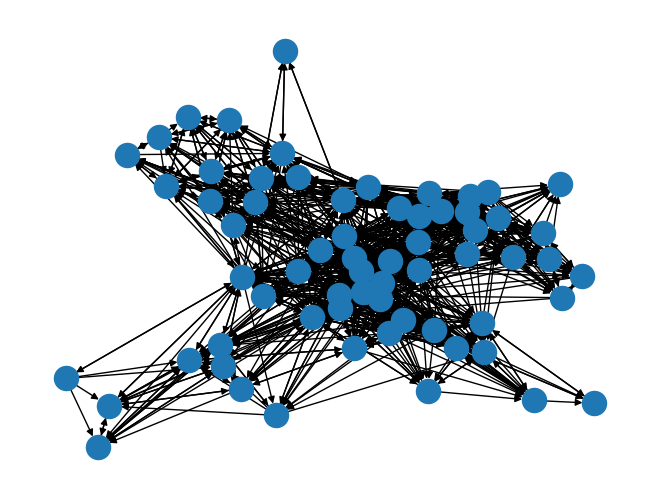

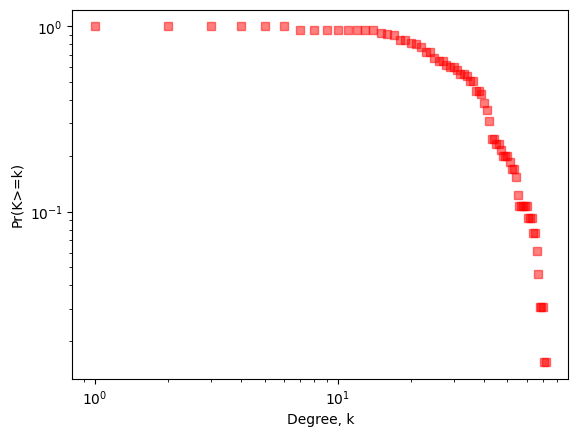

number of nodes, n  = 65
number of edges, m  = 1139
mean degree,    <k> = 35.05
clustering coefficient, C     =  0.47
mean geodesic distance, <ell> =  1.86


In [3]:
s = nx.draw(G, pos = nx.spring_layout(G))
plt.show(s) #spring
n = G.number_of_nodes()
m = G.number_of_edges()
kmean = 2*m/n
C = nx.transitivity(G)
ellmean = nx.average_shortest_path_length(G)
l = sorted(G.degree, key=lambda x: x[1], reverse=True)
list_of_degrees = []
for i in range(len(l)):
    list_of_degrees.append(l[i][1])
def plot_CCDF(kis):
    # input : a list of degrees, e.g., from a networkx graph G
    # output: a plot of the CCDF of the degree distribution Pr(K>=k) for k>=1
    
    kmax = max(kis)

    # histogram and plot
    counts, bins = np.histogram(kis, bins=[i for i in range(kmax+2)], density=True)
    cumcounts = np.cumsum(counts)
    cumcounts = np.insert(cumcounts,0,0)
    plt.loglog(bins[1:-1], 1-cumcounts[1:-1], 'rs', alpha=0.5)
    plt.xlabel('Degree, k')
    plt.ylabel('Pr(K>=k)')
    plt.show()
    return

plot_CCDF(list_of_degrees)



print(f'number of nodes, n  = {n}')
print(f'number of edges, m  = {m}')
print(f'mean degree,    <k> = %5.2f' % kmean)
print(f'clustering coefficient, C     = %5.2f' % C)
print(f'mean geodesic distance, <ell> = %5.2f' % ellmean)

In [5]:
print(G.out_degree('n1'))

10




### Part 1: Rich Club Analysis:

* Compute the degree distribution of the network to determine the rich club regime.
* Calculate the rich club coefficient for different levels of connectivity (k) and compare it with null models to establish rich club organization.
* Identify the top-ranking nodes to form the rich club based on predetermined criteria (top 15 highest-degree nodes).


In [29]:
#compute phi
def compute_phi(G): 
    e = G.number_of_edges()
    n = G.number_of_nodes()
    phi = 0
    if e != 0 and n != 0 and n!= 1:
        phi = e / (n * (n-1))
    else:
        phi = 0
    return phi

In [37]:
#takes in G: a directed unweighted graph
#take sin k, the threshold
#computes in and out degree 
#take nodes where their in and out degree = k
#return subgraph with those nodes
def create_subgraph(k, G):
    subgraph_nodes = []
    for node in nx.nodes(G):
        in_out_count = G.in_degree(node) + G.out_degree(node)
        if in_out_count > k:
            subgraph_nodes.append(node)
    return subgraph_nodes, G.subgraph(subgraph_nodes)


# takes in graph
# returns a tuple: (list of subgraph, list of phi)
# wrapper for create subgraph and create phi function
def subgraph_phi(G, K):
    s_k = [] #nodes in each k 1-68
    phi_k = []
    for k in range(K):
        nodes, subgraph = create_subgraph(k,G)
        s_k.append(nodes)
        phi = compute_phi(subgraph)
        if phi != 0:
            phi_k.append(compute_phi(subgraph))
    return s_k, phi_k


In [38]:
def get_avg(l,k):
    sum = 0
    count = 0
    for list in l:
        if len(list) > k:
            count += 1
            sum += list[k] 
    return sum/count

def compute_ratio(rand_phis, emp_phis):
    ratio = []
    random_avg = []
    for k in range(68):
        random_avg.append(get_avg(rand_phis, k))
    
    for i in range(68):
        rate = emp_phis[i]/random_avg[i]
        ratio.append(rate)
        
    
    return ratio

In [39]:
import random
# create subgraph and phi for empirical data
def compute_phi_empirical(K, G):
    graphs, emp_phis = subgraph_phi(G, K)
    return graphs, emp_phis


# create subgraph and phi for random data
def compute_phi_random(K, G, nrep):
    rand_phis = []
    out_degrees = [d for n, d in G.out_degree()]
    in_degrees = [d for n, d in G.in_degree()]


    for i in range(nrep): # creating nrep random graphs, 68 subgraphs each
        random.seed(i)
        phi = []
        null_graph = nx.directed_configuration_model(in_degree_sequence=in_degrees, out_degree_sequence=out_degrees)
        _, phi = subgraph_phi(null_graph, K)
        rand_phis.append(phi)
    
    return rand_phis

def null_graph_generator(G):
    
    iterate = 1
    G_NULL = nx.DiGraph(G)

    while iterate <= (20*m):

        random_edge_1 = random.choice(list(G_NULL.edges()))
        a, b = random_edge_1

        random_edge_2 = random.choice(list(G_NULL.edges()))
        c, d = random_edge_2

        if a==d or b==c or a==b or c==d:
            break
        else: #swap edge
            #print('here')
            iterate += 1
            G_NULL.remove_edge(a,b)
            G_NULL.add_edge(a,d)
            G_NULL.remove_edge(c,d)
            G_NULL.add_edge(c,b)

    return G_NULL

                

# pair of directed edges
# (a,b) (c,d) a= d then self loop -> reject -> pick a different pair 20m number of times
# (a,d) (c,b)
# (a->b) (c->d)
# replace : (a->d) (c->b)
#check self loop and mutli - edge
#if a = d
# constraits: not every swap allowed -> 
# constraits:a==d or b==c or a==b or c==d reject and choose new pair (no self-loops no multi-edges) 


In [40]:
import random
###
K = 68
nrep = 200
###

nodes_k, empirical_phi = compute_phi_empirical(K, G)
random_phi = compute_phi_random(K, G, nrep)
ratio = compute_ratio(random_phi, empirical_phi)


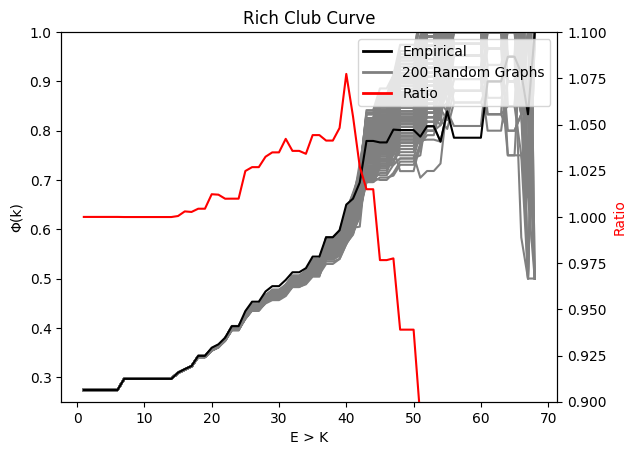

In [41]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()


for i in range(len(random_phi)):
    x_values = list(range(1, len(random_phi[i])+1))
    ax1.plot(x_values, random_phi[i], color='gray')

empirical_x_vals = list(range(1, 69))
ax1.plot(empirical_x_vals, empirical_phi, color='black')
ax2.plot(empirical_x_vals, ratio, color='r')

ax1.set_xlabel('E > K')
ax1.set_ylabel('Φ(k)', color='black')
ax2.set_ylabel('Ratio', color='r')

ax1.set_ylim(0.25, 1)
ax2.set_ylim(0.9, 1.1)
plt.title('Rich Club Curve')

legend_entries = [
    plt.Line2D([0], [0], color='black', lw=2, label='Empirical'),
    plt.Line2D([0], [0], color='gray', lw=2, label='200 Random Graphs'),
    plt.Line2D([0], [0], color='red', lw=2, label='Ratio')
]

# Add the legend with specified entries
plt.legend(handles=legend_entries)

plt.show()



In [43]:
print(len(nodes_k))

68


In [57]:
### Selecting 15 rich club nodes ###

#indexed_list is a tuple conatining the value of ratio and the index or rather (k)
indexed_list = [(value, index) for index, value in enumerate(ratio)]

# sort the list in descending order
sorted_indices = sorted(indexed_list, key=lambda x: x[0], reverse=True)

# Extract the highest ratio and its index
top_15_ratio = [index for value, index in sorted_indices[:15]]


node_degrees = {}
sum = 0

#obtain the sum of in and out degress of the nodes within the threshold k=39 where ratio is the highest
for n in nodes_k[39]:
    sum = 0
    sum = G.in_degree(n) + G.out_degree(n)
    node_degrees[n] = sum

#sort the nodes list in descending order based its value
sorted_keys = sorted(node_degrees, key=lambda x: node_degrees[x], reverse=True)

# Extract the top 15 degree nodes where ratio is at its highest
rich_club_nodes = sorted_keys[:15]
print(rich_club_nodes)


    

['n52', 'n58', 'n15', 'n50', 'n59', 'n51', 'n14', 'n37', 'n11', 'n54', 'n26', 'n40', 'n47', 'n53', 'n25']


Discuss evidence of rich club hubs: <br><br>
Part one focuses on proving the precense of rich club hubs which are relatively small but crucial set of highly connected regions that play a central role in the overall architecture of brain networks. In order to prove this, there needs to be a range of nodes that are highly connected. Since we know high degree nodes are dense and highly connected, we made a subgraph consisting of the top 15 highest-degree nodes and compared it to the Erdos-Renyi and Chung-Lu graph. As expected, the clustering coefficent is much higher than the normalized coefficient in the Erdos-Renyi graph, proving a highly connected and dense hub, in other words, the rich club hub. 


### Part 2: Functional Module Identification:
* Use the provided functional categorization of cortical regions to classify nodes into distinct functional modules (visual, auditory, somatomotor, 
* frontolimbic).
* Apply community detection algorithms to verify the initial module classification and potentially refine it based on network connectivity patterns.


Discuss how hubs are organzied and the architecure:

### Part 3: Node Classification:
* Compute node metrics such as within-module degree z-score and between-module participation coefficient to classify nodes into different roles (intermodal hubs, intramodule hubs).
* Rank nodes based on these metrics and identify nodes that display high levels of intramodular connectivity.


Discuss our findings of the inter and intramodule nodes and what this says about the architecture of the network and how information is passed.

### Part 4: Centrality Analysis: (not sure how to do this)
* Calculate betweenness centrality and PageRank centrality for each node to assess their importance in global network communication.
* Compare centrality metrics across nodes to identify central nodes in the network.


Discuss our findings and what is says about the importance of global network communication

### Part 5: Path Motif Analysis:
* Compute all shortest communication paths in the network and label them with categories of connections (rich club, feeder, local).
* Determine the prevalence of each unique sequence of connections (path motifs) to understand the organization of communication pathways.
* Compare path motif counts with those in randomized networks to assess significance.


Discuss the correlation between type of connection (rich club, feeder, local) and its communcation. what does the correlation tell us about the architerture and how communication is passed.

### Part 6: Statistical Analysis: (for presentation)
* Perform permutation testing to assess statistical significance of group differences on node and connection metrics.
* Evaluate the structural homogeneity and module diversity of connections to understand their role in network organization.


### Part 7: Visualization and Interpretation: (for presentation)
* Visualize the network structure, rich club nodes, functional modules, and communication pathways to gain insights into the organization of the cat brain network.
* Interpret the findings in the context of existing literature and theoretical frameworks related to brain network organization.
